In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import rc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import time
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
import pickle

In [2]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-bright')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Functions

In [3]:
def kmeans(X_km, clusters):
    SSE_arr = []
    ss_arr = []
    for i in clusters:
        print('Cluster: ',i)
        kmeans = MiniBatchKMeans(n_clusters=i, batch_size=1000, max_iter=100)
        clust_dist = kmeans.fit_transform(X_km)
        clust_num = kmeans.predict(X_km)

        SSE = 0
        for a, b in zip(clust_dist, clust_num):
            SSE += a[b] ** 2
        SSE_arr.append(SSE)
        
        if i > 1:
            ss_arr.append(silhouette_score(X_km, clust_num))
    return SSE_arr, ss_arr

In [4]:
def std_f(X_std):
    std_mask = (X_std.dtypes == int) | (X_std.dtypes == np.float64) # only standardize numbers that are not associated with time features
    std_cols = X_std.columns[std_mask]
    ss = StandardScaler()
    X_std[std_cols] = ss.fit_transform(X_std[std_cols])
    return X_std

In [5]:
def silhouette(clusters, ss_arr):
    plt.figure(figsize=(12,8))
    plt.title('Silhouette Scores')
    plt.plot(clusters, ss_arr)
    plt.grid(alpha=0.3)
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score');

## Create Customer Table

In [50]:
def last_visit(row, df):
    add = row.name
    foo = df[ df.address1 == add ].groupby(['address1', 'visit_date']).count()
    num_visits = len(foo)
    return foo.index[num_visits - 1][1]

In [49]:
def days_between_visits(row, df):
    add = row.name
    foo = df[ df.address1 == add ].groupby(['address1', 'visit_date']).count()
    num_visits = len(foo)
    first_visit = foo.index[0][1]
    last_visit = foo.index[num_visits - 1][1]
    return (last_visit - first_visit).days / num_visits

In [53]:
def add_cols(df, cust_table):
    # add in avg items (UPC) per visit
    foo = df.groupby(['address1', 'visit_date']).count()[['qty_shrink_per_day']]
    foo['avg_UPC_per_visit'] = foo['qty_shrink_per_day']
    foo = foo.groupby('address1').mean()[['avg_UPC_per_visit']]
    cust_table = cust_table.join(foo)

    # add in avg days between visits
    cust_table['days_between_visits'] = cust_table.apply(days_between_visits, df=df, axis=1)

    # add in last visit date
    cust_table['last_visit'] = cust_table.apply(last_visit, df=df, axis=1)
    return cust_table

In [37]:
def build_cust_table(df_file):
    try:
        cust_table = pd.read_pickle('data/SRP/cust_table_base.pkl')
    except:
        df = pd.read_pickle(df_file)
        cust_table = df.groupby(['address1']).mean()[['qty_shrink_per_day', 'shrink_value_per_day', 'POP2010',
                                                      'FD_ratio', 'unemp_rate', 'dens_sq_mile', ]].reset_index()
        cust_table.set_index('address1', inplace=True)

        city_i = df.columns.get_loc('city')
        state_i = df.columns.get_loc('state')
        zip_i = df.columns.get_loc('zip_code')
        cust_i = df.columns.get_loc('customer_id')
        for index, row in cust_table.iterrows():
            foo = df[ df.address1 == index]
            for i, r in foo.iterrows():
                city = r[city_i]
                state = r[state_i]
                zip_code = r[zip_i]
                cust_id = r[cust_i]

                cust_table.set_value(index, 'city', city)
                cust_table.set_value(index, 'state', state)
                cust_table.set_value(index, 'zip_code', zip_code)
                cust_table.set_value(index, 'customer_id', cust_id)
                break
        
        cust_table = add_cols(df, cust_table)
        
        cust_table.to_pickle('data/SRP/cust_table_base.pkl')
    return cust_table

In [45]:
df_file = 'data/SRP/clean_data_public_no_crime_lag0.pkl'
cust_table = build_cust_table(df_file)

In [51]:
df = pd.read_pickle('data/SRP/clean_data_public_no_crime_lag0.pkl')
cust_table = add_cols(df, cust_table)

In [55]:
cust_table.head(10)

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,city,state,zip_code,customer_id,avg_UPC_per_visit,days_between_visits,last_visit
address1,,,,,,,,,,,,,
#500 PACWEST/JACKSON,0.038061,0.347094,425363.0,0.228642,0.07,473.294897,BATTLE GROUND,WA,98604,3088198,2.250000,19.250000,2017-11-21
#501 PACWEST/JACKSON,0.041153,0.425020,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,3088198,3.250000,22.000000,2017-12-13
#502 PACWEST/JACKSON,0.035387,0.358387,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,3088198,2.777778,19.555556,2017-12-13
#504 PACWEST/JACKSON,-0.047619,-0.404762,735334.0,0.096296,0.07,4304.958678,PORTLAND,OR,97211,3088198,1.000000,0.000000,2017-10-30
#505 PACWEST/JACKSON,0.030754,0.133134,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,3088198,2.000000,25.500000,2017-11-22
#506 PACWEST/JACKSON,0.439663,2.221883,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,3088198,2.125000,19.250000,2017-12-14
#508 PACWEST/JACKSON,0.227017,1.370558,735334.0,0.096296,0.09,3965.349290,PORTLAND,OR,97220,3088198,4.222222,17.111111,2017-12-14
#509 PACWEST/JACKSON,0.034400,0.231381,735334.0,0.096296,0.08,2925.449871,FAIRVIEW,OR,97024,3088198,3.000000,19.600000,2017-12-21
#511 PACWEST/JACKSON,0.067749,0.472121,529710.0,0.125049,0.07,829.536777,HILLSBORO,OR,97123,3088198,3.250000,19.250000,2017-12-18


In [9]:
dummy_cust = pd.get_dummies(cust_table, columns=['customer_id','zip_code', 'state'])
# including shrink and not inluding dummies
shrink_cust_mask = (dummy_cust.dtypes == float)
shrink_cust_cols = dummy_cust.columns[shrink_cust_mask]

# including dummies but not shrink
dummy_cust_mask = (dummy_cust.dtypes == float) | (dummy_cust.dtypes == np.uint8)
dummy_cust_cols = dummy_cust.columns[dummy_cust_mask]
dummy_cust_cols = list(dummy_cust_cols)
dummy_cust_cols.remove('qty_shrink_per_day')
dummy_cust_cols.remove('shrink_value_per_day')

# including dummies and shrink
all_cust_mask = (dummy_cust.dtypes == float) | (dummy_cust.dtypes == np.uint8)
all_cust_cols = dummy_cust.columns[dummy_cust_mask]

std_cust = std_f(dummy_cust.copy())

## Feature Importance

In [9]:
shrink_cust_cols

Index(['qty_shrink_per_day', 'shrink_value_per_day', 'POP2010', 'FD_ratio',
       'unemp_rate', 'dens_sq_mile'],
      dtype='object')

In [10]:
# feature importance via lasso regression
print('Shape before regularization: ',std_cust[dummy_cust_cols].shape)
lasso = Lasso(alpha=0.001)
lasso.fit(std_cust[dummy_cust_cols], std_cust['shrink_value_per_day'])
model = SelectFromModel(lasso, prefit=True)
std_cust_reduc = model.transform(std_cust[dummy_cust_cols])
feature_idx = model.get_support()
col_names = std_cust[dummy_cust_cols].columns[feature_idx]
print('Shape after regularization: ',std_cust_reduc.shape)
std_cust_reduc
print('Columns to keep: ', col_names)
reg_cols = list(col_names)

pickle.dump(reg_cols, open('data/SRP/reg_cols.pkl', 'wb'))

reg_cols.append('qty_shrink_per_day')
reg_cols.append('shrink_value_per_day')

Shape before regularization:  (11798, 5640)
Shape after regularization:  (11798, 43)
Columns to keep:  Index(['POP2010', 'unemp_rate', 'dens_sq_mile', 'customer_id_1635139',
       'customer_id_1903139', 'customer_id_2331150', 'customer_id_2773156',
       'customer_id_2782156', 'customer_id_3088201', 'customer_id_3089336',
       'customer_id_3093329', 'customer_id_3097348', 'zip_code_06469',
       'zip_code_08610', 'zip_code_14701', 'zip_code_15722', 'zip_code_16743',
       'zip_code_27258', 'zip_code_48180', 'zip_code_53227', 'zip_code_76705',
       'zip_code_83642', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_IN', 'state_KY', 'state_MA', 'state_MD', 'state_MI', 'state_NJ',
       'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_PA', 'state_TN',
       'state_TX', 'state_VA', 'state_WA', 'state_WI', 'state_WV'],
      dtype='object')


## Clustering/Segmentation

In [10]:
# columns to use in segmentation:
#clustering_cols = all_cust_cols
clustering_cols = shrink_cust_cols
clustering_cols

Index(['qty_shrink_per_day', 'shrink_value_per_day', 'POP2010', 'FD_ratio',
       'unemp_rate', 'dens_sq_mile', 'avg_UPC_per_visit'],
      dtype='object')

Cluster:  1
Cluster:  2
Cluster:  3
Cluster:  4
Cluster:  5
Cluster:  6
Cluster:  7
Cluster:  8
Cluster:  9


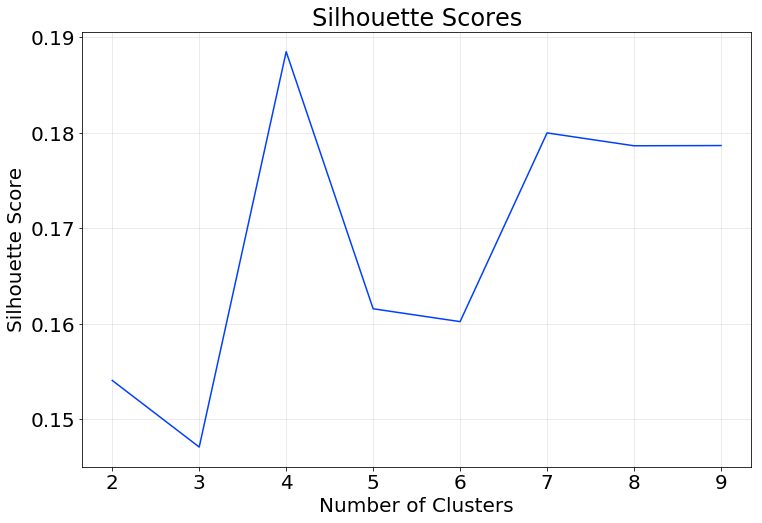

In [11]:
num_clusts = 10
clusters = np.arange(1, num_clusts)
SSE_arr, ss_arr = kmeans(std_cust[clustering_cols], clusters)
#elbow(clusters, SSE_arr)
silhouette(np.arange(2, num_clusts), ss_arr)

In [15]:
cust_kmeans = KMeans(n_clusters=4, max_iter=10000, tol=0.00001, n_jobs=-1)
pred = cust_kmeans.fit_predict(std_cust[clustering_cols])
dummy_cust['cluster'] = pred

In [16]:
# see breakdown of clusters
print(dummy_cust.groupby('cluster').count().city)
dummy_cust.groupby('cluster').mean()[clustering_cols]

cluster
0    1694
1     771
2    4691
3    4642
Name: city, dtype: int64


,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,avg_UPC_per_visit
cluster,,,,,,,
0,0.142213,0.734479,5.765685e+05,0.235901,0.088542,2069.240568,3.379746
1,0.021497,0.116121,7.802109e+06,0.059112,0.081518,19335.715960,2.506935
2,0.015230,0.084557,1.286784e+06,0.144310,0.086112,4220.667798,2.461048
3,0.021567,0.101925,5.962171e+05,0.315593,0.074080,1899.416254,2.852109


### Plot Clusters

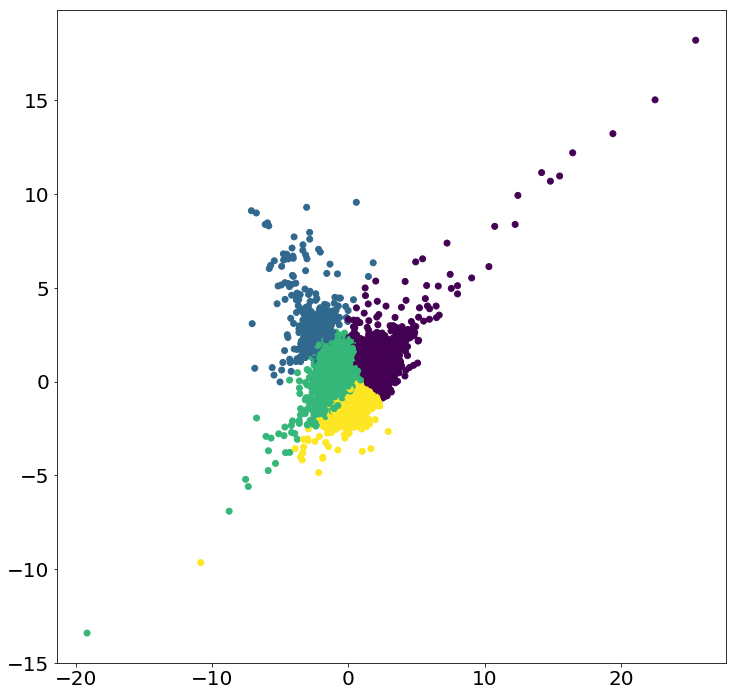

In [17]:
# 2-D plot
cust_pca = PCA(2)
pcas = cust_pca.fit_transform(std_cust[clustering_cols])

plt.figure(figsize=(12,12))
plt.scatter(pcas[:,0], pcas[:,1], c=dummy_cust.cluster);

(-3.8456701056099627, 5)

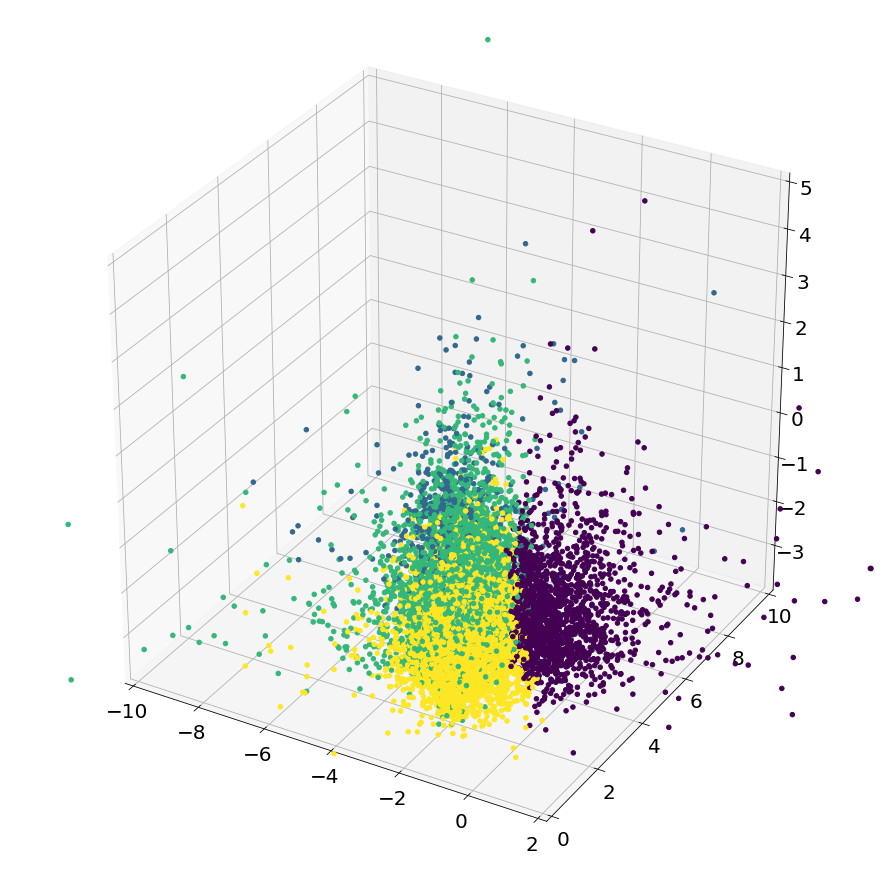

In [18]:
# 3-D Plot
cust_pca = PCA(3)
pcas = cust_pca.fit_transform(std_cust[clustering_cols])

fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
ax.scatter(pcas[:,0], pcas[:,1], pcas[:,2], s=20, alpha=1, c=dummy_cust.cluster)
ax.set_xlim(left=-10, right=2)
ax.set_ylim(bottom=0, top=10)
ax.set_zlim(top=5)

## Append Clusters to Customer Table

In [57]:
#cust_table_clust = cust_table[['cluster']].astype(str)
cust_table_clust = dummy_cust[['cluster']].astype(str)
cust_table_clust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11798 entries, #500 PACWEST/JACKSON to SUPERAMERICA #9398
Data columns (total 1 columns):
cluster    11798 non-null object
dtypes: object(1)
memory usage: 184.3+ KB


In [58]:
cust_table_clust.to_pickle('data/SRP/cust_table_clusters_biased.pkl')

In [61]:
cust_table_agg = cust_table.join(cust_table_clust)
cust_table_agg.to_pickle('data/SRP/cust_table_agg.pkl')